# Experimenting with different networks and datasets


In [1]:
#from torch.utils.data import Dataset
import torchaudio
import torch
#import warnings
#warnings.filterwarnings("ignore")

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data, label_encoder=None):
        # Initialize attributes
        self.data = data["uuid"]
        self.label = data["status"]
        self.label_encoder = label_encoder
        self.sample_rate = {}
        

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Extract audio sample from idx
        audio_path = self.data[idx]

        # Load in audio
        audio_sample, sample_rate = torchaudio.load(audio_path)
        self.sample_rate[idx] = sample_rate
        #info = torchaudio.info(audio_path)
        
        # Extract audio label from idx and transform
        audio_label = [self.label[idx]]
        audio_label = self.label_encoder.transform(audio_label)
        
        # Check if audio sample is stereo -> convert to mono
        if audio_sample.shape[0] > 1:
            #print("Stereo shape:", audio_sample.shape)
            audio_sample = audio_sample.mean(dim=0, keepdim=True)
            #print("after reshaping shape:", audio_sample.shape)
            
        return audio_sample, torch.tensor(audio_label, dtype=torch.int64)
            

    def __get_sample_rate__(self, idx):
        return self.sample_rate.get(idx)

In [2]:
# from IPython.display import Audio
# from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import librosa


# Stolen from pytorch tutorial xd
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

# Collate function


In [3]:
import numpy as np

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.0)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    # A data tuple has the form:
    # waveform, label

    # Separate audio samples and labels
    waveforms, labels = zip(*batch)
    
    # Print the lengths of the waveforms
    #for i, waveform in enumerate(waveforms):
    #    print(f"Waveform {i} length: {len(waveform)}")
    
    # Pad the audio samples
    padded_waveforms = pad_sequence(waveforms)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    #return waveforms, labels
    return padded_waveforms, labels

In [4]:
import pandas as pd



def undersample(data, n, normalize=False):

    # Step 1: Identify majority class

    class_counts = data["status"].value_counts()

    majority_class = class_counts.idxmax()


    # Step 2: Calculate desired class distribution (e.g., balanced distribution)

    desired_class_count = n  # Target number of samples for each class


    # Step 3: Select subset from majority class

    undersampled_data_majority = data[data["status"] == majority_class].sample(
        n=desired_class_count
    )


    # Combine with samples from minority classes

    undersampled_data_minority = data[~(data["status"] == majority_class)]


    # Combine undersampled majority class with minority classes

    undersampled_data = pd.concat(
        [undersampled_data_majority, undersampled_data_minority]
    )


    # Shuffle the undersampled dataset

    undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)

    return undersampled_data

In [5]:
def weighted_sample(data):
    # Find class distribution
    class_counts = data["status"].value_counts()
    # print(class_counts)

    # Check class weights
    class_weights = 1 / class_counts
    # print(class_weights)

    # Adjust weighting to each sample
    sample_weights = [1 / class_counts[i] for i in data["status"].values]
    # print("len sample weights:",len(sample_weights))

    return sample_weights

In [6]:
from sklearn.model_selection import train_test_split

def preprocess_dataset(data, test_size):
    # Extract audio samples and labels
    X = data.drop(columns=["status"])
    y = data["status"]


    # Perform a stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Combine audio samples and target labels for training and validation sets
    train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

    return train_data, test_data

In [7]:
def visualize_dataset(data, normalize, title):
    print(f"{title} Distribution")
    print(data["status"].value_counts(normalize=normalize))
    print("Total samples", len(data))

    plt.figure(figsize=(6, 4))
    plt.title(f"Histogram of Patient Status\n- {title}")
    plt.bar(data["status"].value_counts().index, data["status"].value_counts())
    plt.xticks(rotation=20, ha="right", fontsize=8)
    plt.xlabel("Class", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.show()

In [8]:
import os

def preprocess_data(data_path, data_dir_path):
    # Read data file then remove every column other than the specified columns
    # Removes empty samples and filters through cough probability
    data = pd.read_csv(data_path, sep=",")
    
    data = (
        data[["uuid", "cough_detected", "SNR", "age", "gender", "status"]]
        .loc[data["cough_detected"] >= 0.5]
        .dropna().reset_index(drop=True)
    )

    # Check if the following MP3 with uuid exists
    mp3_data = []
    non_exist = []
    for file in data["uuid"]:
        if os.path.exists(os.path.join(data_dir_path, f"{file}.mp3")):
            #print("Exists!")
            mp3_data.append(os.path.join(data_dir_path, f"{file}.mp3"))
        else:
            #print("Does not exist!")
            non_exist.append(file)
        # elif os.path.exists(os.path.join(data_dir_path, f'{file}.ogg')):
        #    ogg_data.append(os.path.join(data_dir_path, f'{file}.ogg'))

    # Remove entries with missing MP3 files from the original data
    data = data[~data["uuid"].isin(non_exist)]

    # Replace the uuids with the path to uuid
    data["uuid"] = mp3_data

    data.to_csv("audio_data.csv", index=False)
    print("Finished!")

# Define data variables
data_meta = "metadata_compiled.csv"
data_dir_path = r"../Dataset/MP3/"

# Preprocess data if you havent already
#preprocess_data(data_meta, data_dir_path)

# Initialization of dataset


11283
7898
1693
1692
Standard Distribution
status
healthy        0.774120
symptomatic    0.167891
COVID-19       0.057989
Name: proportion, dtype: float64
Total samples 7898


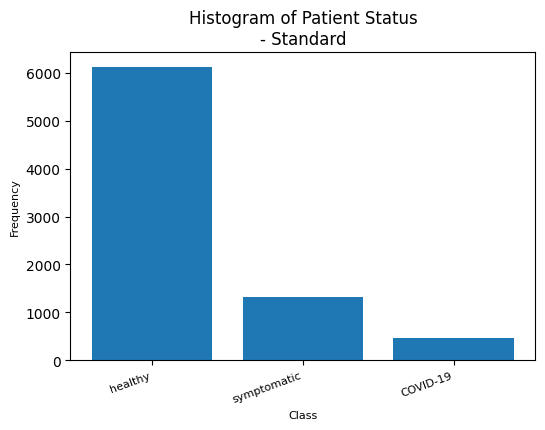

Standard Distribution
status
healthy        0.774232
symptomatic    0.167849
COVID-19       0.057920
Name: proportion, dtype: float64
Total samples 1692


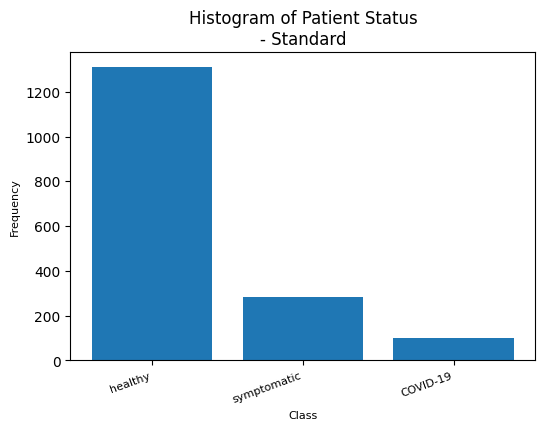

Standard Distribution
status
healthy        0.773774
symptomatic    0.168340
COVID-19       0.057885
Name: proportion, dtype: float64
Total samples 1693


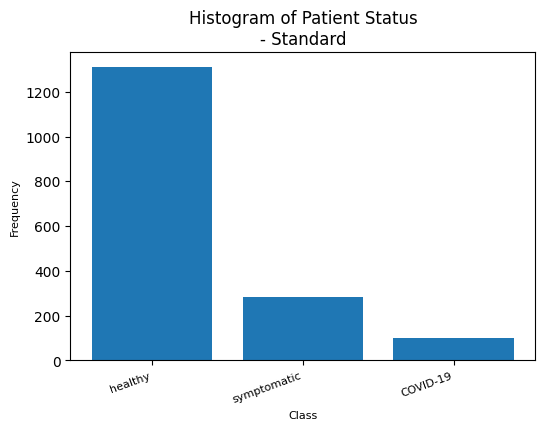

weighted sampler 7898


In [9]:
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
import numpy as np
import os

# Set seed for reproducibility
torch.manual_seed(42)

# Define data variables
data_meta = "metadata_compiled.csv"
data_dir_path = r"../Dataset/MP3/"
data = pd.read_csv("misc_data/audio_data.csv")
#data = pd.read_csv("audio_data2.csv")


# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform labels into encoded form
labels = ["healthy", "symptomatic", "COVID-19"]
encoded_labels = le.fit_transform(labels)

# Visualize standard dataset
# visualize_dataset(data, True, "Standard")
#print("DATASET BEFORE PREPROCESS\n", data)

# Prepare standard dataset
train_data, test_data = preprocess_dataset(data, 0.3) # First split the original dataset into 70% training
val_data, test_data = preprocess_dataset(test_data, 0.5) # Second split the "test_data" into 50/50 validation and test (or technically 15/15)
#print(len(data))
#print(len(train_data))
#print(len(test_data))
#print(len(val_data))

#visualize_dataset(train_data, "normalize", "Standard")
#visualize_dataset(val_data, "normalize", "Standard")
#visualize_dataset(test_data, True, "Standard")

# Create undersampled version
#undersampled_data = undersample(data, 2000, True)

# Visualize undersampled dataset
# visualize_dataset(undersampled_data, True, "Undersampled")

# Prepare undersampled dataset
#train_undersampled_data, test_undersampled_data = preprocess_dataset(
#    undersampled_data, 0.33
#)

# Preparing weighted dataset
sample_weights = weighted_sample(train_data)
weighted_Sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(train_data), replacement=True
)
print("weighted sampler", len(weighted_Sampler))

# Create AudioDataset instances for training and validation sets
"""
We should try training with different datasets such as:
 * Standard
 * Undersampled
 * Weighted

"""
# Standard dataset
train_dataset = AudioDataset(train_data, le)
test_dataset = AudioDataset(test_data, le)

# Undersampled dataset
#train_undersampled_dataset = AudioDataset(train_undersampled_data, le)
#test_undersampled_dataset = AudioDataset(test_undersampled_data, le)

# Create training and test dataloader instances
batch = 10
workers = 0
pin_memory = True

#train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)
#test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)

"""
train_undersampled_dataloader = DataLoader(
    train_undersampled_dataset,
    batch_size=batch,
    shuffle=True,
    num_workers=workers,
    collate_fn=collate_fn,
    pin_memory=True,
)
test_undersampled_dataloader = DataLoader(
    test_undersampled_dataset,
    batch_size=batch,
    shuffle=False,
    num_workers=workers,
    collate_fn=collate_fn,
    pin_memory=True,
)
"""

train_weighted_dataloader = DataLoader(train_dataset, sampler=weighted_Sampler, batch_size=batch, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
test_weighted_dataloader = DataLoader(test_dataset, sampler=weighted_Sampler, batch_size=batch, num_workers=workers, collate_fn=collate_fn, pin_memory=True)

In [10]:
# Testing stuff
#print(train_data)
#print(test_data)
print(train_dataset.__getitem__(7564))
print(train_dataset.__len__())

#train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
"""



import torchaudio.transforms as T




print(t := test.__getitem__(0))



print(t3 := test.__getitem__(1))
print("len t", len(t[0][0]))



print("len t3", len(t3[0][0]))

print(t[0])



print(t[1])




print(t2 := test.__get_sample_rate__(0))




print("decoded label",le.inverse_transform(t[1]))




# Define transform



spectrogram = T.Spectrogram(n_fft=512)




# Perform transform
spec = spectrogram(t[0])



fig, axs = plt.subplots(2, 1)



plot_waveform(t[0], t2, title="Original waveform", ax=axs[0])



plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])



fig.tight_layout()
"""

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0468, 0.0309, 0.0127]]), tensor([1]))
7898


'\n\n\n\nimport torchaudio.transforms as T\n\n\n\n\nprint(t := test.__getitem__(0))\n\n\n\nprint(t3 := test.__getitem__(1))\nprint("len t", len(t[0][0]))\n\n\n\nprint("len t3", len(t3[0][0]))\n\nprint(t[0])\n\n\n\nprint(t[1])\n\n\n\n\nprint(t2 := test.__get_sample_rate__(0))\n\n\n\n\nprint("decoded label",le.inverse_transform(t[1]))\n\n\n\n\n# Define transform\n\n\n\nspectrogram = T.Spectrogram(n_fft=512)\n\n\n\n\n# Perform transform\nspec = spectrogram(t[0])\n\n\n\nfig, axs = plt.subplots(2, 1)\n\n\n\nplot_waveform(t[0], t2, title="Original waveform", ax=axs[0])\n\n\n\nplot_spectrogram(spec[0], title="spectrogram", ax=axs[1])\n\n\n\nfig.tight_layout()\n'

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# import matplotlib.pyplot as plt
# import IPython.display as ipd

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device running on: {device}")


class M5(nn.Module):
    def __init__(self, n_input=1, n_output=3, stride=2, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=10, stride=stride)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d(4)
        self.conv2 = nn.Conv2d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(n_channel)
        self.pool2 = nn.MaxPool2d(4)
        self.conv3 = nn.Conv2d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(2 * n_channel)
        self.pool3 = nn.MaxPool2d(4)
        self.conv4 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(2 * n_channel)
        self.pool4 = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

class ModifiedM5(nn.Module):
    def __init__(self, n_output=3, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, n_channel, kernel_size=(3, 3), stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.conv2 = nn.Conv2d(n_channel, n_channel, kernel_size=(3, 3), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(n_channel)
        self.conv3 = nn.Conv2d(n_channel, 2 * n_channel, kernel_size=(3, 3), stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(2 * n_channel)
        self.conv4 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=(3, 3), stride=(2, 2))
        self.bn4 = nn.BatchNorm2d(2 * n_channel)
        # Adjusted input size for the fully connected layer
        self.fc1 = nn.Linear(2 * n_channel * 2 * 372, n_output)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

#model = ModifiedM5(n_output=len(labels))
#model.to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#n = count_parameters(model)
#print("Number of parameters: %s" % n)

Device running on: cuda


In [12]:
from torchaudio.transforms import MFCC

# Settings for MelSpectrogram computation
melkwargs = {
    "n_mels": 80,  # How many mel frequency filters are used
    "n_fft": 480,  # How many fft components are used for each feature
    "win_length": 480,  # How many frames are included in each window
    "hop_length": 160,  # How many frames the window is shifted for each component
    "center": False,  # Whether frams are padded such that the component of timestep t is centered at t
    "f_max": 7600,  # Maximum frequency to consider
    "f_min": 20,
}

# Instantiate MFCC feature extractor
mfcc = MFCC(
    n_mfcc=40,  # Number of cepstrum components
    sample_rate=16000,  # Sample rate of input audio
    melkwargs=melkwargs,
)  # Keyword arguments for MelSpectogram

In [13]:
import torch.nn.functional as F

def MFCC_Features(data):
    features = mfcc(data)
    features = F.pad(features, (0,6000 - features.shape[3]), "constant", 0).permute(0,1,2,3)
    return features

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import models

#model = fasterrcnn_resnet50_fpn()
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3) 

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model.train()
model.to(device);

# Training


In [15]:
from torch.cuda.amp import GradScaler
from tqdm.notebook import tqdm
import torch.optim as optim

# Defining training variables
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1
)  # reduce the learning after 20 epochs by a factor of 10
log_interval = 20
losses = []

for epoch in range(epochs):
    for i, (inputs, targets) in tqdm(enumerate(
       train_weighted_dataloader),
       total=len(train_weighted_dataloader),
       leave=True,
       desc=f"Epoch {epoch+1}/{epochs} | Training",
    ):
        #print(f"batch idx: {i+1} ", end='\r')
        features = MFCC_Features(inputs)
        
        #print(f"========== BATCH {i} ========== ")
        #for idx, f in enumerate(features):
        #    print(f"{idx+1} | {f.shape}")
        #print(f"========== BATCH {i} ========== ")
        
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if i % log_interval == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i}/{len(train_weighted_dataloader)} | Loss: {loss.item():.4f}")
        
        #loss = F.nll_loss(output.squeeze(), targets)
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        #if i % log_interval == 0:
        #    print(f"Train Epoch: {epoch} [{i * len(data)}/{len(train_dataloader.dataset)} ({100. * i / len(train_dataloader):.0f}%)]\tLoss: {loss.item():.6f}")
        #losses.append(loss.item())
        
        

Epoch 1/5 | Training:   0%|          | 0/790 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model, "model.pth")

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model):
    model.eval()
    correct = 0
    for data, target in test_dataloader:
        data = MFCC_Features(data)
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(f"Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)")
    

model = torch.load("model.pth")
model.to(device)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=pin_memory)
test(model)